In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph


%matplotlib inline

We're gonna start with implementing a 'Value' object for our micrograd

In [3]:
import numpy as np
class Value:

    def __init__(self, data, _children=(), _op='', label=''):

        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # previous components of current output
        self._op = _op # operation of current output
        self.label = label # label of current output

    def __repr__(self): # outputs a more readable version of the object

        return (f"Value(data={self.data})")
    
    def __add__(self, other):

        output = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * output.grad
            other.grad = 1.0 * output.grad

        output._backward = _backward
        return output
    
    def __mul__(self, other):

        output = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = [other.data*output.grad]
            other.grad = [self.data*output.grad]

        output._backward = _backward
        return output
    
    def tanh(self):

        x = self.data
        t = (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
        output = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * output.grad

        output._backward = _backward
        return output

In [4]:

x = Value(3.0, label='x')
y = Value(2.0, label='y')
z = Value(7.0, label='z')
a = x*z
a.label='a'
c = a + y
c.label = 'c'   
f = Value(-3.0, label='f')
L = c*f; L.label = 'L'
L1 = L.data

In [95]:
print(x+y)
print(x*y)
print(x*z + y)

Value(data=5.0)
Value(data=6.0)
Value(data=23.0)


^^^Addition and Multiplication Function well^^^

In [5]:
print(a._prev) #first value of prev should be 21 and second should be 2
print(c._op)
print(c.label)

{Value(data=7.0), Value(data=3.0)}
+
c


Now that we know _prev and _op work fine, we need a method of visualizing our results and the progression of nodes as things become more complex

In [6]:
def trace(root):
    
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):

    assert rankdir in ['LR', 'TB']

    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    # create operation nodes to symbolize the operation interaction
    # between two previous nodes to result in the 
    # subsequent node
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

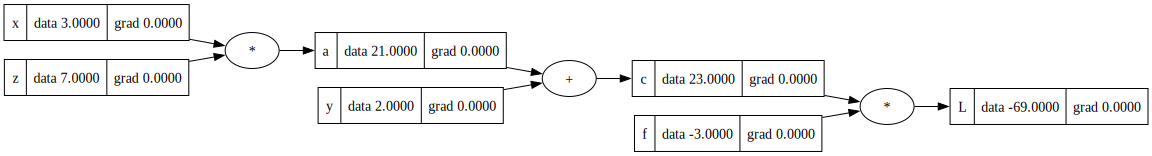

In [7]:
draw_dot(L)

In [19]:
'''with neurons'''

#inputs to Neural Network
x1 = Value(3.0, label = 'x1')
x2 = Value(4.0, label = 'x2')

#weights on inputs
w1 = Value(-2.0, label = 'w1')
w2 = Value(5.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

#let's construct a final sum
# x1 * w1 + x2 * w2 + b

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b; n.label = 'n'

#incorporate activation function (tanh)
out = n.tanh()
out.label = 'out'


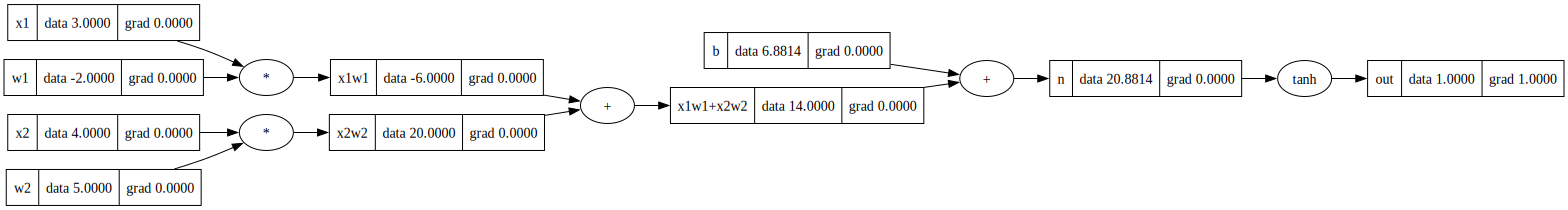

In [24]:
draw_dot(out)

In [21]:
out.grad = 1.0

In [25]:
out._backward()